In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from drive.MyDrive.datas.module.preprocess import *
from drive.MyDrive.datas.module.setting_tf import *

In [ ]:
dataset = get_dataset()
print(dataset.shape)
dataset.tail(2)

(10051, 3)


,image_path,status,where
10049,/content/Dataset/train/painting/75979dda5331ee...,painting,train
10050,/content/Dataset/train/painting/003323259a6612...,painting,train


In [ ]:
weight_path = os.path.join(os.getcwd(), "drive/MyDrive/datas/model_result")

model_weights = glob.glob(weight_path + "/*.h5")
model_weights

['/content/drive/MyDrive/datas/model_result/mobilenet_acc.h5',
 '/content/drive/MyDrive/datas/model_result/mobilenet_loss.h5',
 '/content/drive/MyDrive/datas/model_result/resnet_acc.h5',
 '/content/drive/MyDrive/datas/model_result/resnet_loss.h5',
 '/content/drive/MyDrive/datas/model_result/inception_resnet_acc.h5',
 '/content/drive/MyDrive/datas/model_result/inception_resnet_loss.h5',
 '/content/drive/MyDrive/datas/model_result/inception_v3_acc.h5',
 '/content/drive/MyDrive/datas/model_result/inception_v3_loss.h5',
 '/content/drive/MyDrive/datas/model_result/efficientnet_acc.h5',
 '/content/drive/MyDrive/datas/model_result/efficientnet_loss.h5']

In [ ]:
model_names = []
for weight in model_weights:
  name = "_".join(os.path.basename(weight).split("_")[:-1])
  model_names.append(name)

print(model_names)

['mobilenet', 'mobilenet', 'resnet', 'resnet', 'inception_resnet', 'inception_resnet', 'inception_v3', 'inception_v3', 'efficientnet', 'efficientnet']


In [ ]:
def get_scores(model, weights, name, inplace=False):
  scores = []
  for weight in weights:
    model.load_weights(weight)

    output = model.predict(X_valid)
    result = [1 if num >= 0.5 else 0 for num in output.flatten()]

    cnt = 0
    for i in range(len(result)):
      if result[i] != y_valid[i]:
        cnt += 1

    scores.append(cnt)
    
  print(f"{name} Acc Model >> Wrong Predict Count :{scores[0]}, Accuracy Rate :{np.round((len(y_valid) - scores[0]) / len(y_valid), 4)}")
  print(f"{name} Loss Model >> Wrong Predict Count :{scores[1]}, Accuracy Rate :{np.round((len(y_valid) - scores[1]) / len(y_valid), 4)}")
  print()

  if inplace:
    return scores

In [ ]:
scores = {"name": [], "score": []}
for i in range(0, len(model_weights), 2):
  
  weights = model_weights[i:i+2]
  name = model_names[i]
  if name != "inception_v3":
    datas = split_train_valid_df(dataset=dataset, img_size=224, shuffle=False)
    base_model = load_base_model(name, input_shape=(224, 224, 3), trainable=False)
  else:
    datas = split_train_valid_df(dataset=dataset, img_size=299, shuffle=False)
    base_model = load_base_model(name, input_shape=(299, 299, 3), trainable=False)

  X_valid, y_valid = split_X_y_dataset(datas=datas, get_train=False, get_valid=True)
  X_valid = X_valid / 255.0

  model = make_network(base_model, name)
  model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

  model_scores = get_scores(model, weights, name, inplace=True)
  
  for num in range(2):
    scores["name"].append(weights[num])
    scores["score"].append(model_scores[num])

mobilenet Acc Model >> Wrong Predict Count :318, Accuracy Rate :0.8944
mobilenet Loss Model >> Wrong Predict Count :321, Accuracy Rate :0.8934

resnet Acc Model >> Wrong Predict Count :305, Accuracy Rate :0.8987
resnet Loss Model >> Wrong Predict Count :334, Accuracy Rate :0.889

inception_resnet Acc Model >> Wrong Predict Count :350, Accuracy Rate :0.8837
inception_resnet Loss Model >> Wrong Predict Count :375, Accuracy Rate :0.8754

inception_v3 Acc Model >> Wrong Predict Count :317, Accuracy Rate :0.8947
inception_v3 Loss Model >> Wrong Predict Count :331, Accuracy Rate :0.89

efficientnet Acc Model >> Wrong Predict Count :286, Accuracy Rate :0.905
efficientnet Loss Model >> Wrong Predict Count :286, Accuracy Rate :0.905



In [ ]:
scores_df = pd.DataFrame(scores)

scores_df["name"] = scores_df["name"].apply(lambda x: x.split("/")[-1].split(".")[0])
scores_df.sort_values("score", inplace=True)
scores_df.head()

,name,score
0,/content/drive/MyDrive/datas/model_result/mobi...,318
1,/content/drive/MyDrive/datas/model_result/mobi...,321
2,/content/drive/MyDrive/datas/model_result/resn...,305
3,/content/drive/MyDrive/datas/model_result/resn...,334
4,/content/drive/MyDrive/datas/model_result/ince...,350
5,/content/drive/MyDrive/datas/model_result/ince...,375
6,/content/drive/MyDrive/datas/model_result/ince...,317
7,/content/drive/MyDrive/datas/model_result/ince...,331
8,/content/drive/MyDrive/datas/model_result/effi...,286
9,/content/drive/MyDrive/datas/model_result/effi...,286


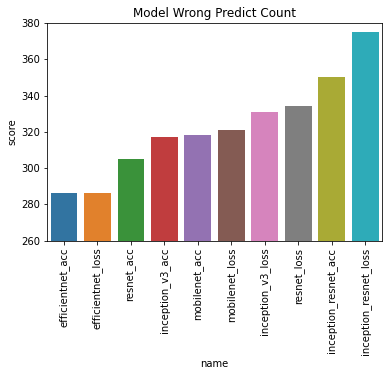

In [ ]:
sns.barplot(data=scores_df, x='name', y='score')
plt.xticks(rotation=90)
plt.ylim((260, 380))
plt.title("Model Wrong Predict Count")

plt.show()